
# Bài tập buổi 6

In [43]:
# import libs
import numpy as np

###1. Hiểu kiến trúc autoencoder. [Optional] Hiểu và code hàm tính deconvolution, transposed convolution (visualization https://github.com/vdumoulin/conv_arithmetic...)

**Kiến trúc AutoEncoder**

AutoEncoder được sử dụng để giảm chiều dữ liệu và học features.
Kiến trúc của một model AutoEncoder như sau:

$\displaystyle x \; \rightarrow \; f(x) \; \rightarrow \; z \; \rightarrow \; g(z) \; \rightarrow \; \hat{x}$

Trong đó, $f(x)$ được coi là phần encoder dùng để giảm chiều dữ liệu và $g(z)$ được coi là phần decoder để khôi phục lại dữ liệu như ban đầu. $f(x)$ và $g(z)$ có thể là một NN, CNN, hay LinearRegression, ...

Loss của model được định nghĩa dựa trên giá trị $\hat{x}$ decode được và giá trị $x$ đầu vào.

Hàm loss có thể là MSE hoặc crossentropy nếu x thuộc khoảng (0, 1)

**Code hàm deconvolution**

In [44]:
def deconvolution(X, kernel, stride=2, padding=1):
  # param
  height = X.shape[0]
  width = X.shape[1]
  k = kernel.shape[0]

  # create output matrix
  output_width = (width - 1) * (stride - 1)  + width + k - 1
  output_height = (height - 1) * (stride - 1) + height + k - 1

  output = np.zeros((output_height, output_width))

  # stride process
  for row in range(height):
    for col in range(width):
      t = X[row, col] * kernel
      output[row * stride : row * stride + k, col * stride : col * stride + k] = output[row * stride : row * stride + k, col * stride : col * stride + k] + t
  
  # padding process
  if padding != 0:
    output_padding = output[padding : - padding, padding : - padding]
  else:
    output_padding = output[padding : , padding : ]

  return output_padding

In [45]:
# test decovolution
x = np.array([
              [1, 2, 3],
              [3, 4, 5],
              [5, 6, 7]
])

kernel = np.array([
                   [1, 1, 0],
                   [0, 0, 1],
                   [0, 1, 0]
])

res1 = deconvolution(x, kernel, 1, 0)
res1

array([[ 1.,  3.,  5.,  3.,  0.],
       [ 3.,  7., 10.,  7.,  3.],
       [ 5., 12., 18., 14.,  5.],
       [ 0.,  3.,  9., 11.,  7.],
       [ 0.,  5.,  6.,  7.,  0.]])

In [46]:
def transposedConvolution(X, kernel, stride=2, padding=1):
  # param
  height = X.shape[0]
  width = X.shape[1]
  k = kernel.shape[0]

  z = stride - 1
  p = k - padding - 1

  # create medial matrix 
  t_height = z * (height - 1) + height + 2 * p
  t_width = z * (width - 1) + width + 2 * p
  t = np.zeros((t_height, t_width))

  for row in range(height):
    for col in range(width):
      t[p + row * stride, p + col * stride] = X[row, col]

  # create output matrix
  output_height = t_height - k + 1
  output_width = t_width - k + 1

  output = np.zeros((output_height, output_width))

  for row in range(output_height):
    for col in range(output_width):
      output[row, col] = np.sum(t[row : row + k, col : col + k] * kernel)

  return output

In [47]:
res2 = transposedConvolution(x, kernel, stride=1, padding=0)
res2

array([[ 0.,  1.,  2.,  3.,  0.],
       [ 1.,  5.,  7.,  5.,  0.],
       [ 3., 10., 14., 12.,  3.],
       [ 5.,  9., 14.,  9.,  5.],
       [ 0.,  5., 11., 13.,  7.]])

###2. Tự tạo dataset, thực hiện denoise ảnh cifar-10

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import keras
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam
from matplotlib import pyplot as plt

In [49]:
(x_train, _), (x_test, _) = cifar10.load_data()

In [50]:
x_train, x_val = train_test_split(x_train, test_size=10000)

In [51]:
print('Train size: \t', x_train.shape[0])
print('Val size: \t', x_val.shape[0])
print('Test size: \t', x_test.shape[0])

Train size: 	 40000
Val size: 	 10000
Test size: 	 10000


In [52]:
print('Data shape: ', x_train[0].shape)

Data shape:  (32, 32, 3)


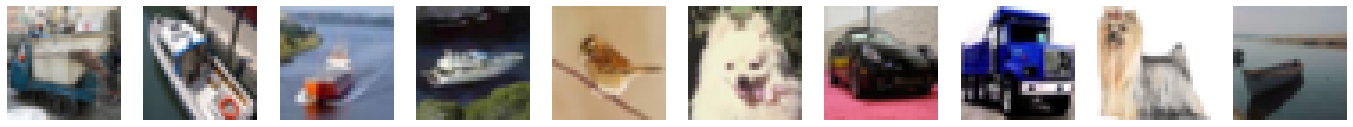

In [53]:
# plot some samples
plt.figure(figsize=(24, 8))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(x_train[i])

plt.show()

In [54]:
# normalize
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

In [55]:
# add noise too dataset
def add_noise(x, factor=0.2):
    x = x + np.random.rand(* x.shape) * factor
    x = x.clip(0., 1.)
    return x

x_train_noisy = add_noise(x_train, 0.1)
x_val_noisy = add_noise(x_val, 0.1)
x_test_noisy = add_noise(x_test, 0.1)

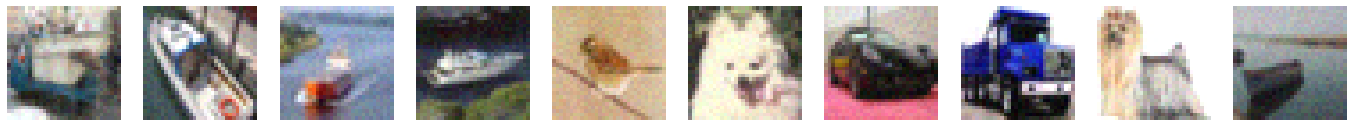

In [56]:
# plot some samples
plt.figure(figsize=(24, 8))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(x_train_noisy[i])

plt.show()

In [64]:
# define a AutoEncoder model
def AutoEncoder(input_shape):
  inputs = Input(shape=input_shape)
  
  # encode
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  x = MaxPooling2D()(x)

  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)

  x = Reshape((4, 4, 8))(x)

  # decode
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D()(x)

  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D()(x)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D()(x)

  x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

  model = Model(inputs=inputs, outputs=x, name='AutoEncoder')
  model.compile(optimizer=Adam(), loss='binary_crossentropy')
  return model

In [65]:
auto_encoder = AutoEncoder((32, 32, 3))
auto_encoder.summary()

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 8)           

In [66]:
H = auto_encoder.fit(x_train_noisy, x_train, validation_data=(x_val_noisy, x_val), epochs=100, batch_size=128)

Epoch 1/100
313/313 [==============================] - 38s 12ms/step - loss: 0.6357 - val_loss: 0.5951
Epoch 2/100
313/313 [==============================] - 3s 10ms/step - loss: 0.5932 - val_loss: 0.5887
Epoch 3/100
313/313 [==============================] - 3s 10ms/step - loss: 0.5888 - val_loss: 0.5869
Epoch 4/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5857 - val_loss: 0.5843
Epoch 5/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5847 - val_loss: 0.5831
Epoch 6/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5840 - val_loss: 0.5822
Epoch 7/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5828 - val_loss: 0.5833
Epoch 8/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5821 - val_loss: 0.5810
Epoch 9/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5813 - val_loss: 0.5805
Epoch 10/100
313/313 [==============================] - 3s 11ms/step - loss: 0.58

In [67]:
score = auto_encoder.evaluate(x_test_noisy, x_test)
score

313/313 [==============================] - 1s 3ms/step - loss: 0.5728


0.5728422999382019

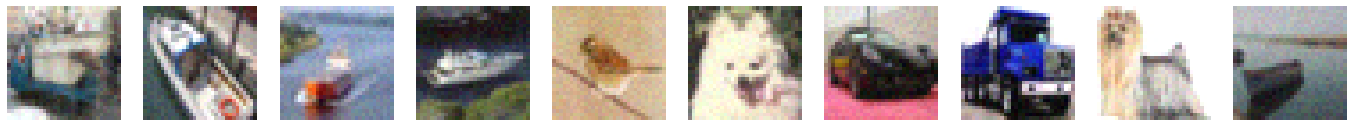

In [69]:
plt.figure(figsize=(24, 8))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(x_train_noisy[i])

plt.show()

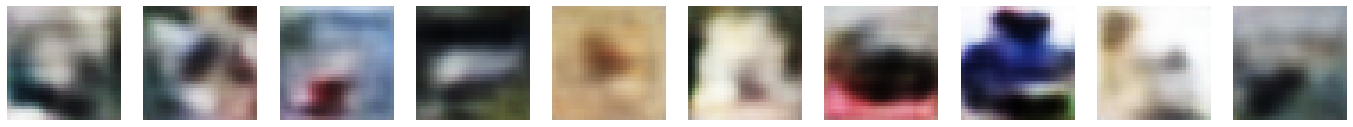

In [70]:
# denoise
test_sample = x_train_noisy[:10]
test_result = auto_encoder.predict(test_sample)
plt.figure(figsize=(24, 8))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_result[i])

plt.show()

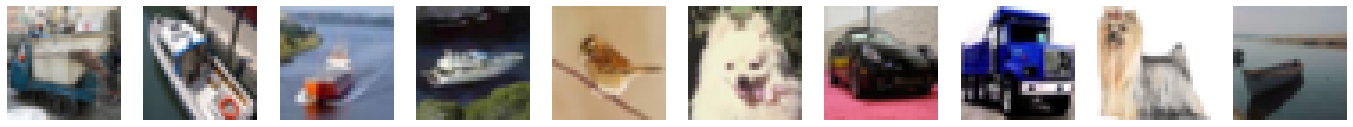

In [71]:
# original
plt.figure(figsize=(24, 8))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(x_train[i])

plt.show()

###3. Giảm chiều dữ liệu cifar-10 về 2d, visualize và so sánh giữa PCA ( https://scikit-learn.org/.../sklearn.decomposition.PCA...), neural network AE và convolutional AE.

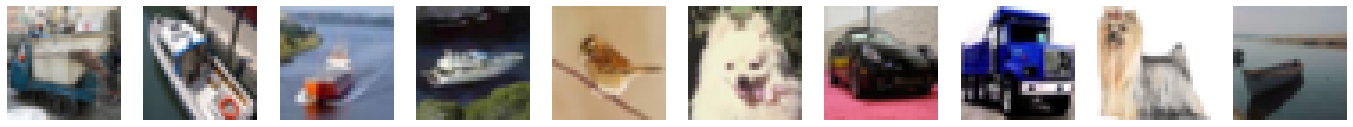

In [88]:
# Original
plt.figure(figsize=(24, 8))
for i, a in enumerate(x_train[:10]):
  plt.subplot(1, 10, i+1)
  plt.imshow(a)
  plt.axis('off')

plt.show()

In [124]:
# Neural network autoencoder
auto_encoder_nn = AutoEncoder((32, 32,  3))
auto_encoder_nn.summary()

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 8)           

In [139]:
auto_encoder_nn.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=300, batch_size=128)

Epoch 1/300
313/313 [==============================] - 4s 11ms/step - loss: 0.5731 - val_loss: 0.5726
Epoch 2/300
313/313 [==============================] - 3s 11ms/step - loss: 0.5731 - val_loss: 0.5733
Epoch 3/300
313/313 [==============================] - 3s 10ms/step - loss: 0.5730 - val_loss: 0.5728
Epoch 4/300
313/313 [==============================] - 3s 10ms/step - loss: 0.5729 - val_loss: 0.5724
Epoch 5/300
313/313 [==============================] - 3s 10ms/step - loss: 0.5729 - val_loss: 0.5724
Epoch 6/300
313/313 [==============================] - 3s 10ms/step - loss: 0.5727 - val_loss: 0.5723
Epoch 7/300
313/313 [==============================] - 3s 10ms/step - loss: 0.5727 - val_loss: 0.5725
Epoch 8/300
313/313 [==============================] - 3s 11ms/step - loss: 0.5727 - val_loss: 0.5727
Epoch 9/300
313/313 [==============================] - 3s 10ms/step - loss: 0.5726 - val_loss: 0.5722
Epoch 10/300
313/313 [==============================] - 3s 11ms/step - loss: 0.572

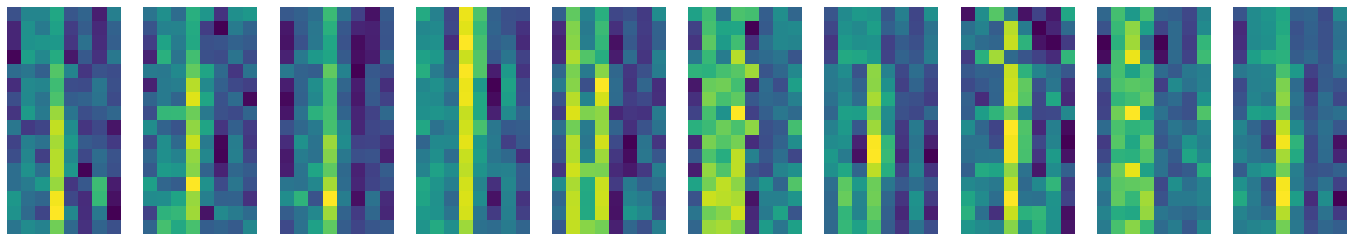

In [140]:
# Visualize latent from neural network AutoEncoder
latent = auto_encoder_nn.get_layer("flatten_4").output
input = auto_encoder_nn.get_layer('input_10').input
model = Model(inputs=input, outputs=latent)
pred = model.predict(x_train[:10])

plt.figure(figsize=(24, 8))
for i, a in enumerate(pred):
  b = a.reshape((16, 8))
  plt.subplot(1, 10, i+1)
  plt.imshow(b)
  plt.axis('off')

plt.show()

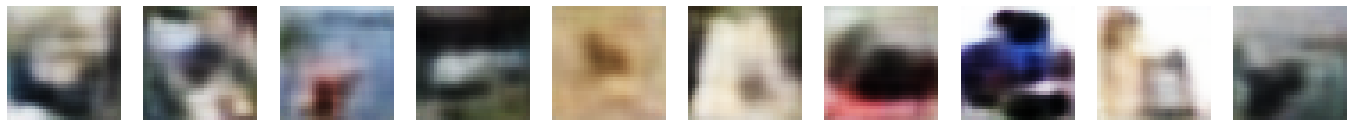

In [141]:
b = auto_encoder_nn.predict(x_train[:10])
plt.figure(figsize=(24, 8))
for i, a in enumerate(b):
  plt.subplot(1, 10, i+1)
  plt.imshow(a)
  plt.axis('off')

plt.show()

In [142]:
# Neural network auto encoder loss
score = auto_encoder_nn.evaluate(x_test, x_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.5693


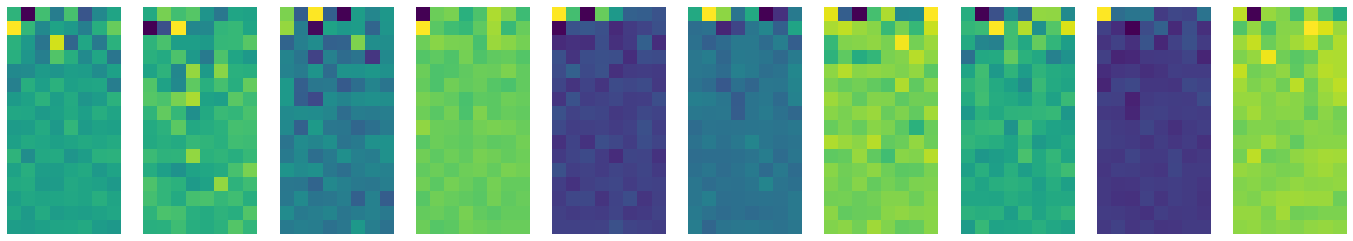

In [136]:
# PCA
pca = PCA(n_components=128)
plt.figure(figsize=(24, 8))
b = pca.fit_transform(x_train.reshape(40000, -1))
for i, a in enumerate(b[:10]):
  plt.subplot(1, 10, i+1)
  plt.imshow(a.reshape((16, -1)))
  plt.axis('off')

plt.show()

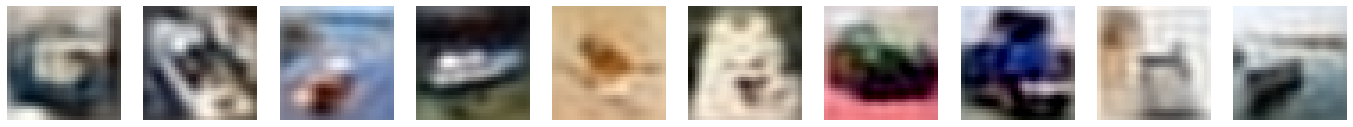

In [137]:
c = pca.inverse_transform(b[:10])
plt.figure(figsize=(24, 8))
for i, a in enumerate(c):
  plt.subplot(1, 10, i+1)
  a = a.astype('float64') / np.max(a)
  a = a.clip(0., 1.)
  plt.imshow(a.reshape(32, 32, 3))
  plt.axis('off')

plt.show()

In [138]:
pca.score(x_test.reshape(10000, -1))

3415.8324045551076

**Nhận xét:** PCA cho chất lượng nén tốt hơn và tốc độ nhanh hơn so với NNAE. Còn NNAE có lẽ sẽ cho kết quả tốt hơn nếu training đủ kỹ.